## Gaussian Prediction

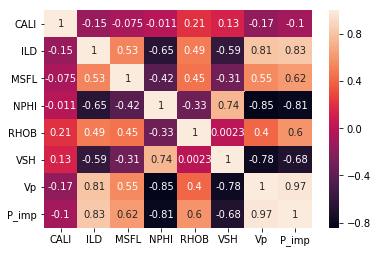

In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import lasio
import seaborn as sns
las = lasio.read(r'puk1.las')

"""
depth in ft
DT in mus/ft
rhob in g/cc
Vp in m/s
P Impedance in m/s g/cc
"""

"""
load sumur 1
"""

df=las.df()
gr_max=df['GR'].max()
gr_min=df['GR'].min()
df['VSH']=(df['GR']-gr_min)/(gr_max-gr_min)
df['Vp']=1/df['DT']*10**(6)
df['P_imp']=df['Vp']*df['RHOB']

#rename column
df=df.rename(columns={'NPHI_LS':'NPHI'})

#drop column which have no record
df_drop=df.dropna(subset=['P_imp'],axis=0)

#select only at the target area
df_target=df_drop.loc[3337.79:3751.5].reset_index()

"""
load sumur 2
"""
las2 = lasio.read(r'pum1.las')

df2=las2.df()
gr_max=df2['GR'].max()
gr_min=df2['GR'].min()
df2['VSH']=(df2['GR']-gr_min)/(gr_max-gr_min)
df2['Vp']=1/df2['DT']*10**(6)
df2['P_imp']=df2['Vp']*df2['RHOB']

#rename column
df2=df2.rename(columns={'NPHI_LS':'NPHI'})

#drop column which have no record
df2_drop=df2.dropna(subset=['P_imp'],axis=0)

#select only at the target area
df2_target=df2_drop.loc[3327.15:3701.74].reset_index()

#combine sumur 1 dan 2
df_com=pd.concat([df_target,df2_target]).reset_index(drop=True)
df_com.set_index('DEPTH',inplace=True)
df_com.drop(columns=['GR','DT'],inplace=True)

corrmap=df_com.corr()
sns.heatmap(corrmap,annot=True)
plt.show()



### Creating PDF and CDF

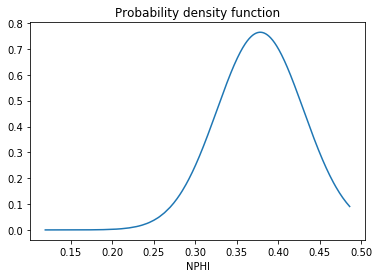

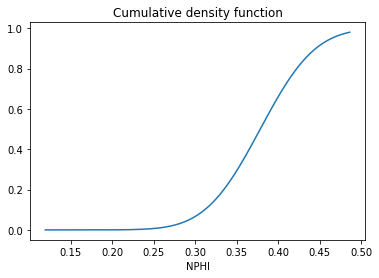

In [7]:
# split X and y
#X=df_com[['Vp']]
X=df_com[['ILD','VSH','Vp','P_imp']]
y=df_com[['NPHI']]

#test and train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2,random_state=0)

#standardizing data
from sklearn.preprocessing import StandardScaler

sc=StandardScaler().fit(X_train)
X_train_std=sc.transform(X_train)
X_test_std=sc.transform(X_test)

#creating pdf function from porosity
from scipy.stats import norm
import numpy as np
from statistics import stdev
from sklearn import preprocessing


y_sort=y.sort_values(by='NPHI')
y_sort=y_sort['NPHI']
y_mean=y_sort.mean()
y_std=stdev(y_sort)

y2=norm.pdf(y_sort,y_mean,y_std)
y2=y2/10

z=norm.cdf(y_sort,y_mean,y_std)
z2=z/10

plt.figure()

plt.plot(y_sort, y2)
plt.xlabel('NPHI')
plt.title('Probability density function')
plt.show()

plt.figure()

plt.plot(y_sort, z)
plt.xlabel('NPHI')
plt.title('Cumulative density function')
plt.show()



### MODEL Using Gaussian 

r2 score of well #1 & #2 is: 0.7314456056006391
RMS error for well #3 is: 0.000571510208116118
r2 score of well #3 is: 0.6802228352327588


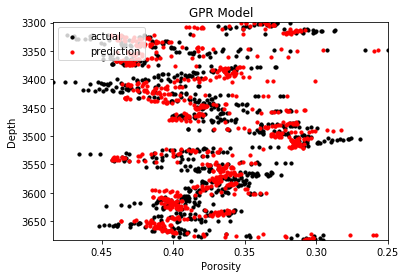

In [10]:
import sklearn.gaussian_process as gp

kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
model.fit(X_train_std, y_train)
params = model.kernel_.get_params()

y_pred, std = model.predict(X_test_std, return_std=True)

#model performance
from sklearn.metrics import mean_squared_error,r2_score

test_r2_score=r2_score(y_test, y_pred)
print(test_r2_score)

"""
Load sumur 3
"""

las3 = lasio.read(r'pux2.las')


df3=las3.df()
gr_max=df3['GR'].max()
gr_min=df3['GR'].min()
df3['VSH']=(df3['GR']-gr_min)/(gr_max-gr_min)
df3['Vp']=1/df3['DT']*10**(6)
df3['P_imp']=df3['Vp']*df3['RHOB']

#rename column
df3=df3.rename(columns={'NPHI_LS':'NPHI'})

#drop column which have no record
df3_drop=df3.dropna(subset=['P_imp'],axis=0)

#select only at the target area
#df3_target=df3_drop.loc[3316.28:3651.67].reset_index() #uxa-1
df3_target=df3_drop.loc[3299.43:3683.01].reset_index() #ux-2

#X3=df3_target[['Vp']]
X3=df3_target[['ILD','VSH','Vp','P_imp']]
y3=df3_target[['NPHI']]


sc=StandardScaler().fit(X3)
X3_std=sc.transform(X3)
y3_pred, std3 = model.predict(X3_std, return_std=True)

rmse3=mean_squared_error(y3,y3_pred)
test3_r2_score=r2_score(y3, y3_pred)
print("RMS error for well #3 is: " + str(rmse3))
print("r2 score of well 3 is: "+ str(test3_r2_score))

#plotting check overlay
y3['NPHI_pred']=y3_pred
y3=y3.sort_index()

plt.figure()
plt.scatter(y3['NPHI'],df3_target['DEPTH'],c='k',label='actual',s=10)
plt.scatter(y3['NPHI_pred'],df3_target['DEPTH'],c='r',label='prediction',s=10)
plt.legend(loc='upper left');
plt.ylim(df3_target['DEPTH'].max(),df3_target['DEPTH'].min())
plt.xlim(y3['NPHI'].max(),y3['NPHI'].min())
plt.xlabel('Porosity')
plt.ylabel('Depth')
plt.title('GPR Model')
plt.show()


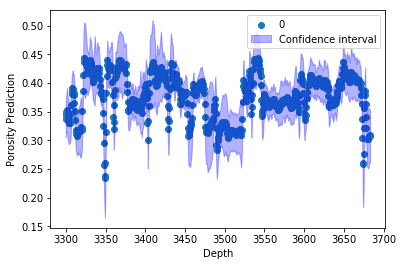

In [11]:
#confidence interval 95%

a=df3_target['DEPTH']
b=pd.DataFrame(y3_pred)
b=b[0]

ci = 1.96 * std3
#ci=np.array(ci)

fig, ax = plt.subplots()
ax.scatter(a,b)
ax.fill_between( a,(b-ci), (b+ci),  color='b', alpha=.3)
plt.xlabel('Depth')
plt.ylabel('Porosity Prediction')
ax.collections[1].set_label('Confidence interval')
ax.legend()
plt.show()